# INCIDENCIA DEL CANCER A NIVEL GLOBAL Y EUROPA

Fernando Moro Cordobés

## Introducción

El cáncer constituye una de las principales causas de mortalidad en los seres humanos. Recientemente se ha puesto de manifiesto que el número de personas diagnosticadas con algún tipo de cáncer ha [incrementado a nivel global](https://www.infobae.com/salud/2025/02/05/aumentan-los-casos-de-cancer-en-menores-de-50-anos-la-ciencia-busca-las-razones/).

Más allá de la búsqueda de nuevos métodos de diagnosis y terapias, el análisis de los datos de la enfermedad en las distintas zonas del planeta contribuye al estudio relacional de los factores diferenciales en aquellas poblaciones donde existe mayor incidencia. Además, arroja una imagen de aquellos lugares donde es más necesaria la financiación de la atención oncológica y paliativa.

El proyecto [_Cancer Incidence in Five continents_ (CI5)](https://ci5.iarc.fr/ci5plus/)  es una colaboración entre _International Agency for Research on Cancer_ y _International Association of Cancer Registries_ cuyo objetivo es recopilar los datos de incidencia del cáncer en distintos países a lo largo del tiempo. En este trabajo se ha utilizado la dataset del proyecto CI5 para realizar una comparativa del número de casos detectados a lo largo de los últimos años en los distintos continentes. Además se han analizado datos a nivel del continente europeo, profundizando en aquellos países donde el número de casos fue más alto.

Para cada región, el número de casos para un tipo de cáncer específico es expresado como el número de casos por cada 100000 habitantes. En el dataset original existen regiones diferentes para un mismo país. Como no conocemos los habitantes de cada región no podemos hacer un promedio ponderado de los casos, asi que se ha tratado como un promedio simple, es decir sumando el número de casos y dividiendo por el número de regiones.

## Código y Resultados

### Importación y preparación del dataset inicial

In [2]:
# Importamos las librerias necesarias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

# Cargamos el data set original
cancer_total = pd.read_csv("/CI5plus_Detailed/data.csv", sep = ",")

# Cargamos el data set con los paises y continentes
countries = pd.read_csv("/CI5plus_Detailed/id_dict.csv", sep = ",")

# Cargamos el data set con los tipos de cancer
cancer_kind = pd.read_csv("/CI5plus_Detailed/cancer_dict.csv", sep = ",")

In [ ]:
""" 
Primero, sustituimos introducimos una columna con el nombre del país dentro del dataFrame de countries
a partir del country code. Utilizamos para ello un csv que contiene los valores asociados a cada pais. 
La finalidad de esto es lograr una columna con el nombre del país nada más
"""

# Cargamos el csv nuevo (https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv)

paises_codigo = pd.read_csv("/CI5plus_Detailed/country_3digit_code.csv", sep = ",")
countries.columns

Index(['CI5_continent', 'id_code', 'id_label', 'ethnic_code', 'country_code',
       'registry_code'],
      dtype='object')

In [5]:
# Unimos el dataFrame countries con el nuevo mediante la columna del código

countries_combined = pd.merge(countries, paises_codigo, left_on="country_code", right_on="country-code")
# countries_combined.head()

# Conservamos las columnas de id_code (para combinar con el dataFrame de cancer total),
# la columna name(el nombre del pais) y la columna region (el continente)

countries_definitivo = countries_combined[["id_code", "name", "region"]]
# countries_definitivo.head()

In [6]:
# Creacion de una serie con el índice de los valores que aparecen en dataframe de cancer total
# y los rangos etarios correspondientes

df_edad = pd.DataFrame({"edad": ["0-4",  "5-9", "10-14",
                                 "15-19", "20-24", "25-29",
                                 "30-34","35-39", "40-44", 
                                 "45-49","50-54", "55-59",
                                "60-64", "65-69", "70-74",
                                "75-79", "80-85", "85+"]},
                                 index=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

# Tambien creamos una serie con el sexo

sexo = pd.DataFrame({"sexo":["Hombre", "Mujer"]}, index=[1,2])

In [7]:
""" 
A partir de aquí vamos a concatenar los nombres de países, continentes, tipos de cancer, rangos de edad y el sexo en 
el dataFrame de cancer total. La finalidad de esto es poner más clara la información, sin que esté codificada.
Esto facilitará su entendimiento y estudio
"""
# concatenamos información de paises
cancer_total_contries = pd.merge(cancer_total, countries_definitivo, on="id_code")

# concatenamos información de tipos de cáncer
cancer_total_contries_tipos = pd.merge(cancer_total_contries, cancer_kind, on="cancer_code")

# concatenmos rangos etarios
cancer_total_contries_tipos_edad = pd.merge(cancer_total_contries_tipos, df_edad, left_on="age", right_index=True)

# concatenamos sexo
cancer_total_contries_tipos_edad_sexo = pd.merge(cancer_total_contries_tipos_edad, sexo, left_on="sex", right_index=True)

# Establecemos el dataFrame definitivo con las columnas de nuestro interés
""" 
cases: número de casos diagnosticados
year: año
name: país
region: continente
cancer_label: tipo de cancer
edad: rango de edad de pacientes
sexo: sexo biológico
"""
cancer_def = cancer_total_contries_tipos_edad_sexo[["cases", "year", "name", "region", "cancer_label", "edad", "sexo"]]

# Vamos a Excluir las filas correspondientes a el valor "All cancers excluding non-melanoma skin" dentro de la columna cancer_label.
# Este valor incluye varios tipos de cánceres, y sólo queremos trabajar con categorias bien definidas.

cancer_def = cancer_def[cancer_def["cancer_label"] != "All cancers excluding non-melanoma skin"]

# Comprobamos que no hay valores faltantes
cancer_def.isna().sum()

cases           0
year            0
name            0
region          0
cancer_label    0
edad            0
sexo            0
dtype: int64

In [8]:
# Estudiamos las dimensiones del dataFrame final y el tipo de dato que contiene cada columna
cancer_def.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21884148 entries, 19 to 23236618
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   cases         int64 
 1   year          int64 
 2   name          object
 3   region        object
 4   cancer_label  object
 5   edad          object
 6   sexo          object
dtypes: int64(2), object(5)
memory usage: 1.3+ GB


### Análisis de los datos a nivel de continente

Pregunta 1. Existen diferencias entre los continentes respecto al número de casos diagnosticados de 
diferentes tipos de cáncer.

Hipótesis: El número de casos de cáncer diagnosticados difiere entre los continentes a lo largo de los años.

In [9]:
# Para poner a prueba la hipótesis primero comprobamos para que periodo de tiempo
# existen datos para todos los continentes
pd.set_option('display.max_columns', None)
tabla = cancer_def.groupby(["region", "year"])[["cases"]].count().unstack()
tabla.isna().sum().unstack()

year,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
cases,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Con eso comprobamos que el periodo para el que existen datos para todos los continentes es desde 1993 hasta 2017, por lo que trabajaremos con ese periodo.

In [10]:

# Creamos un nuevo dataFrame con el periodo de tiempo entre 1993-2017:

cancer_93_17 = cancer_def[cancer_def["year"] >= 1993]

In [11]:

# Calculamos el promedio de casos/100000 hab por país en cada año
promedio_casos_por_pais = cancer_93_17.groupby(["region", "year", "name"])[["cases"]].mean().reset_index()

# Calculamos con los datos anteriores el promedio de casos de cada continente por año
promedio_de_continente = promedio_casos_por_pais.groupby(["region", "year"])[["cases"]].mean().reset_index()

# Es importante que estamos suponiendo que el número de habitantes es similar entre distintas regiones de un mismo país y entre países 
# dentro de un mismo continente.Esto es un gran error pero lo asumimos con fines educativos.

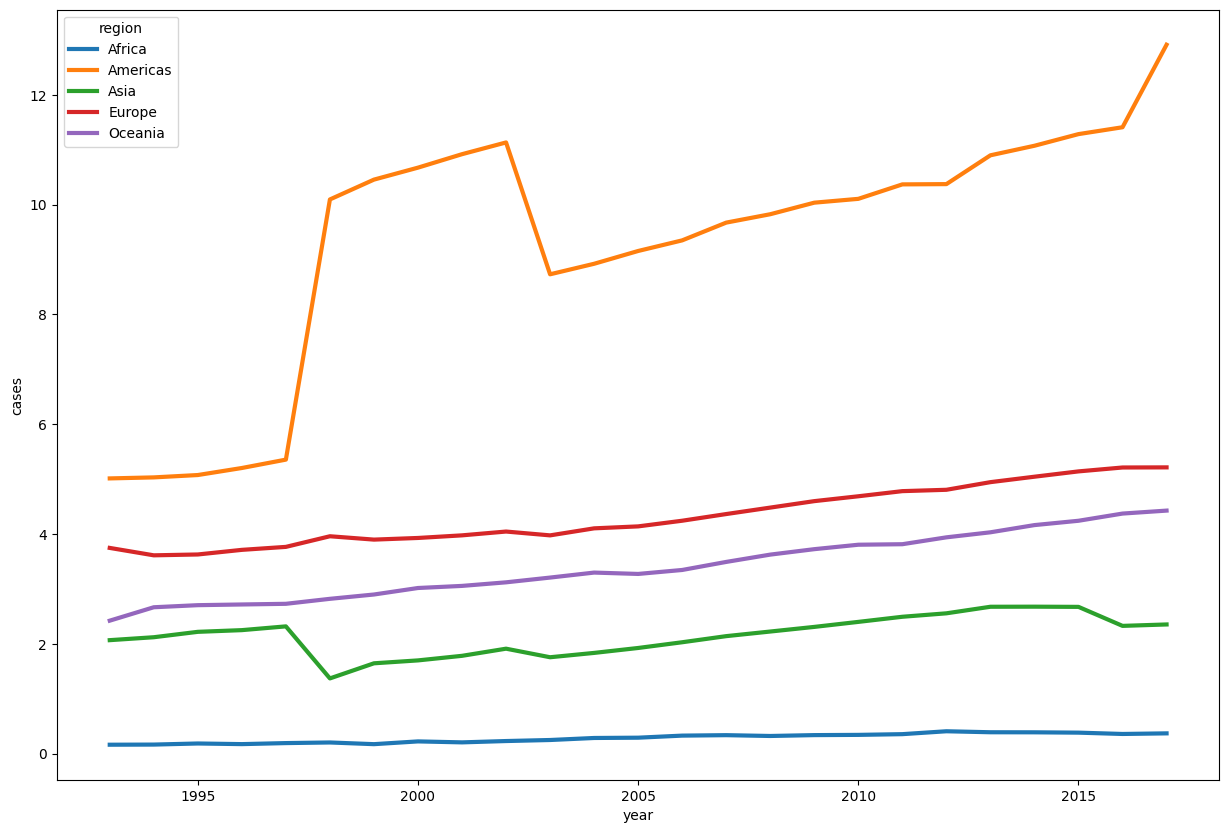

In [12]:
# Representamos gráficamente la evolución de casos por año en cada continente

plt.figure(figsize=(15,10))
sns.lineplot(data=promedio_de_continente,
             x="year",
             y="cases",
             hue="region",
            linewidth = 3);

Confirmamos la hipótesis de que existen diferencias entre el número de casos de cáncer diagnosticados entre 
los diferentes continentes. Estas diferencias se pueden deber a múltiples factores, como genéticas, estilo de vida, accesibilidad a medios sanitarios, organización en la toma de datos, avances en la tecnología de diagnosis..etc

Al observar que entre el año 1997 y 1998 el número de casos diagnosticados con algun tipo de cáncer en América
experimenta un dramático ascenso, buscamos en los datos a que puee ser debido. Hipotetizamos que puede
deberse a que países pertenecientes a dicho continente empezaron a aportar información.

In [13]:
# Creamos un dataFrame para analizar los datos del contienente Americano entre los años 1997 y 1998,
# que es cuando se produce el ascenso de casos.
problema_Americas = cancer_93_17[(cancer_93_17["region"]=="Americas") & (cancer_93_17["year"] >= 1997) & (cancer_93_17["year"] <= 1998)]

problema_Americas[problema_Americas["year"]==1997]["name"].unique()

problema_Americas[problema_Americas["year"]==1998]["name"].unique()

array(['Chile', 'Colombia', 'Costa Rica', 'Ecuador', 'Canada',
       'United States of America'], dtype=object)

Con esto comprobamos que en el año 1998 se suman Chile al conteo de casos. Confirmando que esto puede ser la fuente de incremento repentino en el número de casos diagnosticados.

In [14]:
# Con esto comprobamos que otros países como Argentina no contribuyen con datos hasta el año 2003.
cancer_93_17[cancer_93_17["name"] == "Argentina"]["year"].unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017])

Existe una problemática importante. La incorporación de países en diferentes años a lo largo
de la serie temporal constituye otra fuente de variabilidad que hace que la comparación de los
datos a determinado nivel no sea estadísticamente correcta.

### Análisis de los datos a nivel de Europa

Esta gran variabilidad hace que la comparación entre continentes presente un alto grado de error. 

A partir de aquí vamos a estudiar las potenciales diferencias en los casos de cáncer dentro del continente europeo a lo largo del
periodo entre 1998 y 2017.
Indagaremos en cuáles fueron los tipos de cáncer más comunmente diagnosticados a lo largo de dicho periodo, si existen diferencias entre la edad de las personas diagnosticadas y si el sexo es algo que influya en dicho diagnóstico.

In [15]:
# Estudio de las diferencias de diagnostico de cáncer en el continente europeo entre los años 1993 y 2017

# Creamos el dataFrame con los datos de los países europeos
cancer_europe = cancer_93_17[cancer_93_17["region"] == "Europe"]

# Conteo de cánceres más comunes en Europa
cancer_europe.groupby("cancer_label")["cases"].sum().sort_values(ascending=False)



cancer_label
Lung                             4840980
Breast                           2605993
Prostate                         2222048
Bladder                          1762490
Colon                            1548686
Corpus uteri                      955935
Rectum                            880271
Ovary                             727229
Oesophagus                        704568
Melanoma of skin                  667215
Stomach                           658524
Non-Hodgkin lymphoma              589652
Brain, central nervous system     586456
Kidney                            544867
Pancreas                          542072
Liver                             536386
Lymphoid leukaemia                511115
Cervix uteri                      488689
Thyroid                           450428
Myeloid leukaemia                 424900
Testis                            269031
Multiple myeloma                  241610
Larynx                            187770
Hodgkin lymphoma                  184440
Gal

Los cánceres más comunes con los que trabajaremos a partir de ahora son: Lung, Breast, Prostate, Bladder y Colon. Para visualizar como se distribuyen los promedios de casos a lo largo del periodo realizamos una representación tipo boxplot de los países del continente Europeo.

In [16]:
# Actualizamos el dataFrame de europa para solo incluir los datos de los tipos de cánceres más comunes

common_cancer = ["Lung", "Breast", "Prostate", "Bladder", "Colon"]

cancer_europe = cancer_europe[cancer_europe["cancer_label"].isin(common_cancer)]

# Vamos a reemplazar los nombres largos de Reino Unido y holanda para mejorar las representaciones gráficas
cancer_europe['name'] = cancer_europe['name'].str.replace('United Kingdom of Great Britain and Northern Ireland', 'United K.')

cancer_europe['name'] = cancer_europe['name'].str.replace('Netherlands, Kingdom of the', 'Netherlands')

# Creamos un DataFrame con el promedio de casos diagnosticados cada año en cada país y lo representamos gráficamente. 
casos_totales_europa = cancer_europe.groupby(["year", "name"])[["cases"]].mean().reset_index()
casos_totales_europa

,year,name,cases
0,1993,Austria,1.498677
1,1993,Belarus,19.681217
2,1993,Croatia,12.473545
3,1993,Czechia,32.240741
4,1993,Denmark,21.867725
...,...,...,...
512,2017,Poland,4.919312
513,2017,Slovenia,10.505291
514,2017,Spain,3.910582
515,2017,Switzerland,2.266138


<Figure size 1500x3000 with 0 Axes>

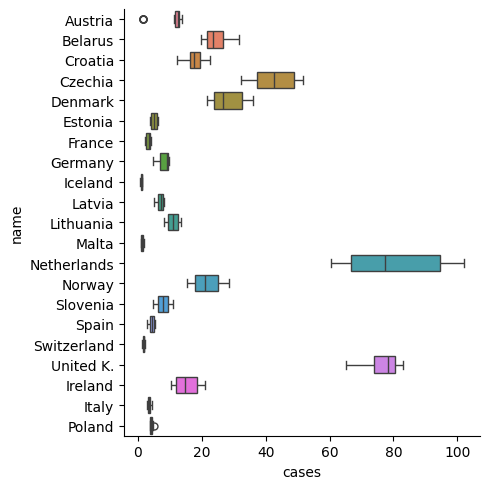

In [17]:
# BoxPlot de los diagnosticos de canceres comunes en cada pais en europa a lo largo del periodo 1993 - 2017
plt.figure(figsize=(15,30))
sns.catplot(x="cases", y="name", kind="box", hue="name", data=casos_totales_europa);


El gráfico de caja muestra como se distribuyen los promedios de casos a lo largo del periodo de enlos diferentes países. Se observa en Netherlands (Holanda) y el reino unido (United K.) existen promedios más altos de canceres diagnosticados respecto a los demás países.

Vamos a representar gráficamente como han evolucionado el promedio de diagnósticos de los cánceres más comunes en los países europeos a lo largo de los años en el periodo 1993-2017.

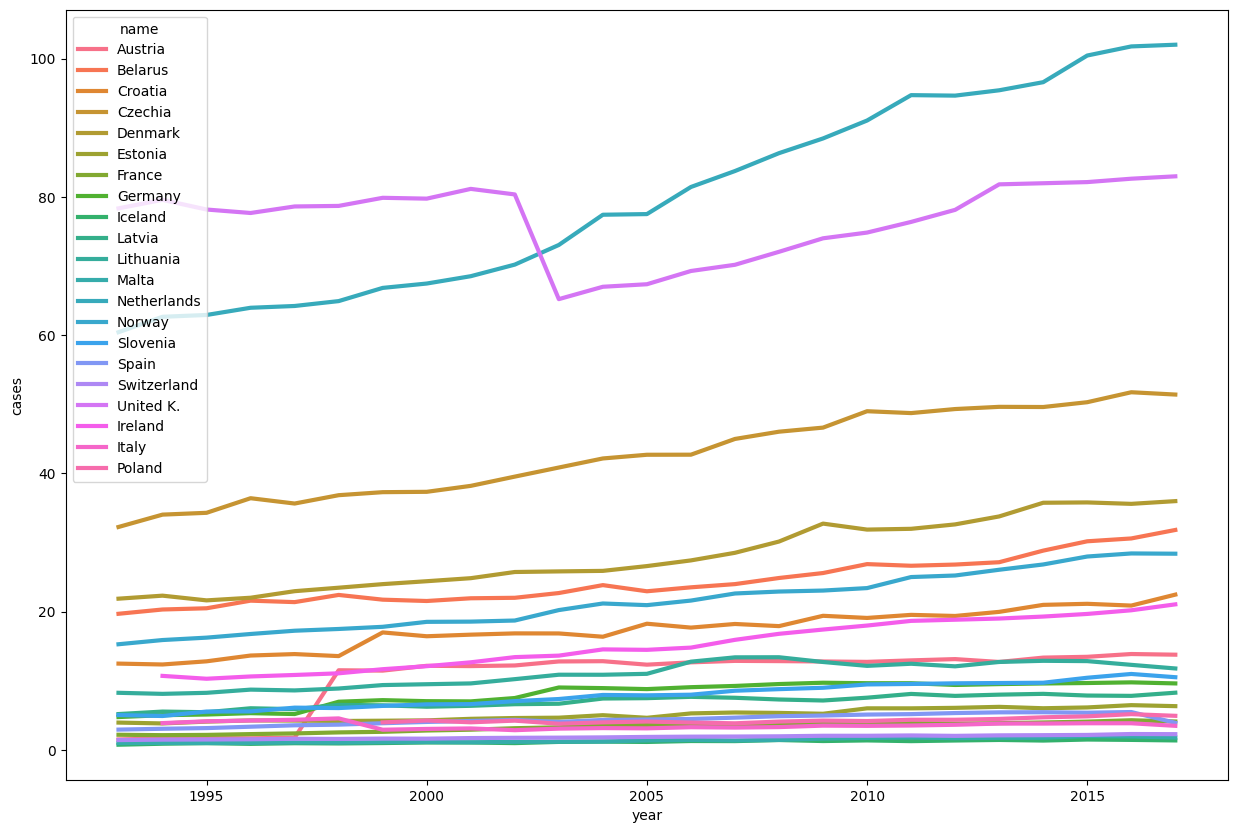

In [18]:
# Gráfico de línea del número de casos diagnosticados de canceres comunes por pais en europa a lo largo del periodo 1993 - 2017

plt.figure(figsize=(15,10))
sns.lineplot(data=casos_totales_europa,
             x="year",
             y="cases",
             hue="name",
            linewidth = 3);


El análisis gráfico muestra como el Reino Unido y Holanda son los países donde más casos de los 5 tipos de cánceres se han diagnosticado en el periodo entre 1993 y 2017. Además se observa una tendencia en el aumento del promedio de casos en el periodo señalado en varios países.

In [19]:
# Vamos a modificar los valores de edad para que no haya tantos diferentes

def rango_etario(x):
    if x == "0-4" or x == "5-9" or x == "10-14":
        return "0-15"
    elif x == "15-19" or x == "20-24" or x == "25-29":
        return "15-29"
    elif x == "30-34" or x == "35-39" or x == "40-44" or x == "45-49":
        return "30-49"
    elif x == "50-54" or x == "55-59" or x == "60-64" or x == "65-69":
        return "50-69"
    else:
        return ">70"
    

cancer_europe["edad"] = cancer_europe["edad"].apply(rango_etario)

### Análisis de los datos de Reino Unido y Holanda

Dado el alto número de casos en Reino Unido y Holanda, vamos a estudiar como se distribuyen los promedios de casos por año para cada uno de los 5 tipos de cánceres más comunes. Primero lo analizaremos por edad y sexo, y después analizaremos como ha evolucionado a lo largo de los años del periodo 1993-2017.

In [20]:
# Comenzamos por crear dos dataFrames separados para cada uno de los países

cancer_uk = cancer_europe[cancer_europe["name"] == "United K."]

cancer_hol = cancer_europe[cancer_europe["name"]== "Netherlands"]

In [46]:
# Calculamos el promedio de casos por tipo de cancer, edad y año  en UK y Netherlands

promedio_casos_UK = cancer_uk.groupby(["cancer_label", "edad", "year","sexo"])[["cases"]].mean().reset_index()

promedio_casos_ned = cancer_hol.groupby(["cancer_label", "edad", "year","sexo"])[["cases"]].mean().reset_index()

### Análisis de los datos en Reino Unido

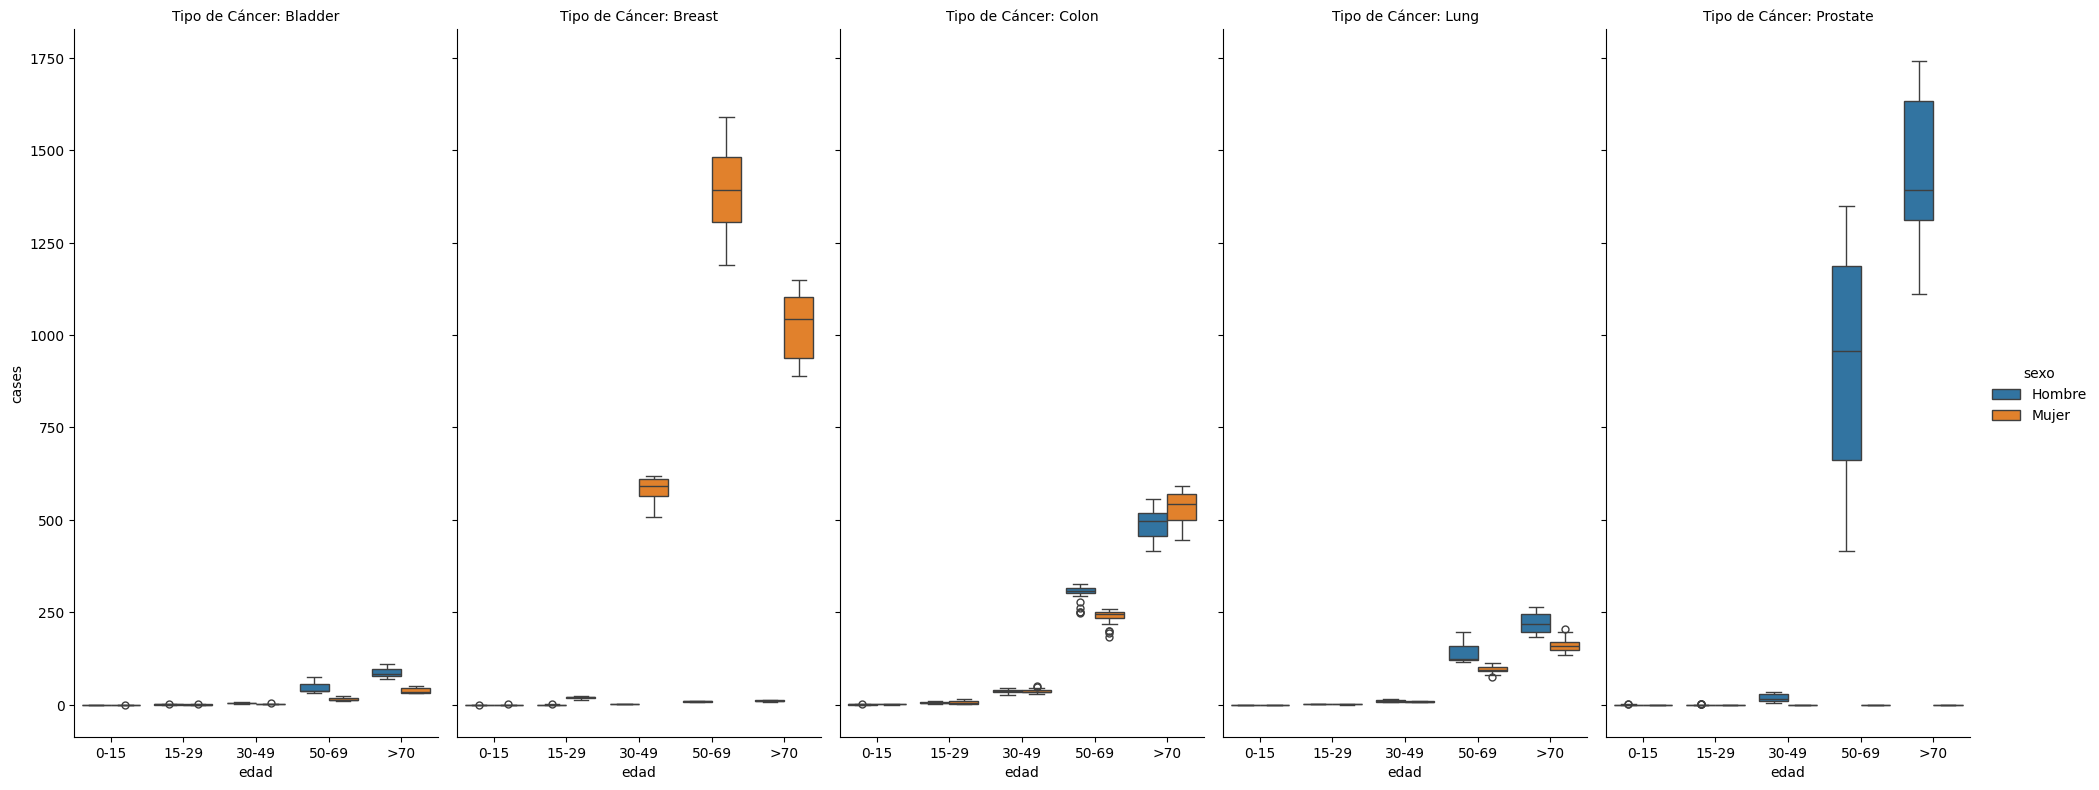

In [45]:
# Representamos gráficamente el número de casos a lo largo de los años para cada sexo y edad, 
# en cada tipo de cáncer en UK

a = sns.catplot(x="edad",
            y="cases",
            hue="sexo",
            col="cancer_label",
            kind = "box",
            data=promedio_casos_UK,
            height=8,
            aspect=0.5)
a.set_titles("Tipo de Cáncer: {col_name}")
a;

Podemos observar en los gráficos que en todos los tipos de cancer el número de casos aumenta con la edad.
Además es de destacable que el número de cánceres de pecho (breast) diagnosticados en hombres es 
prácticamente 0. Como es lógico, no existen casos de cáncer de próstata en mujeres. La mayor variabilidad en el promedio de casos a lo largo del periodo ocurrió en los diagnosticados de cáncer de próstata, seguifo por los diagnósticos de cáncer de mama.

In [26]:
# Estudiamos la evolución de los casos diagnosticados de cada tipo de cancer en el periodo
# 1993-2017 en UK

tipo_cancer_uk = cancer_uk.groupby(["cancer_label", "year"])[["cases"]].mean().reset_index()

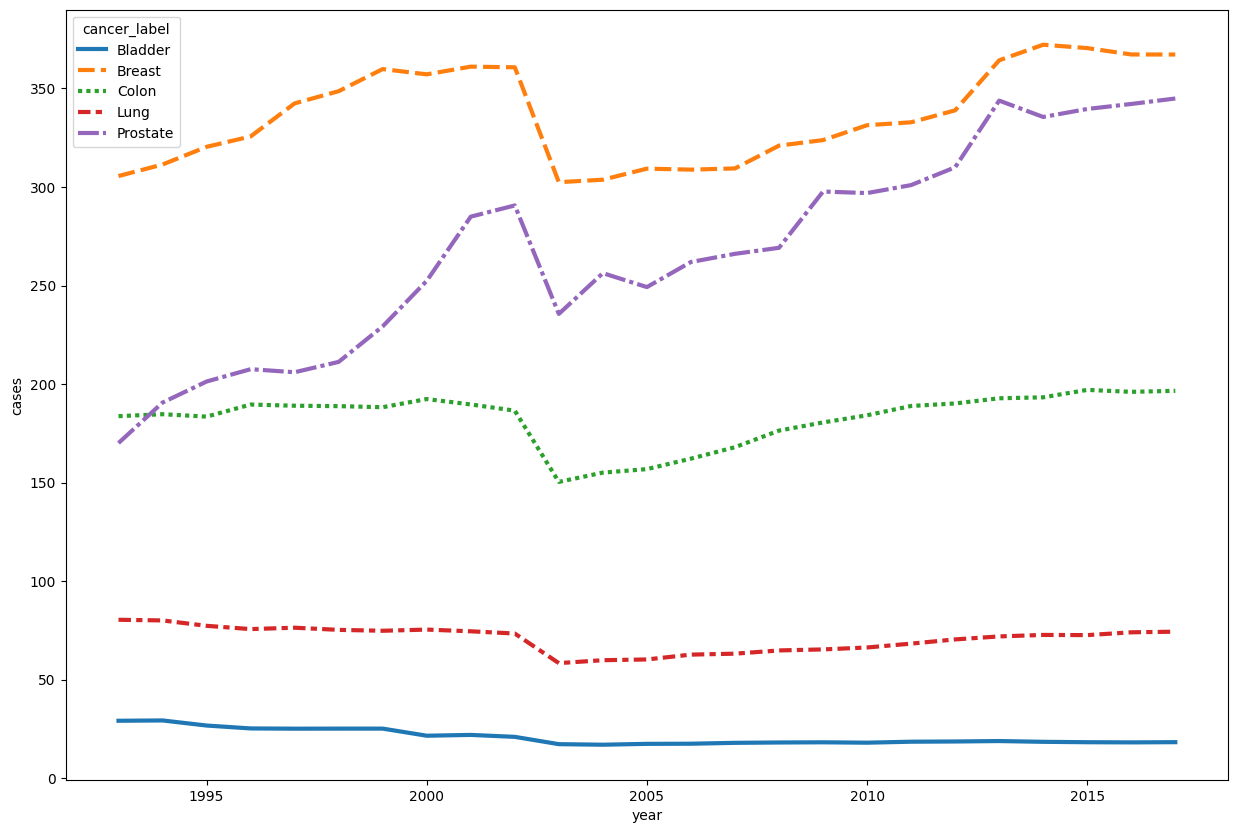

In [ ]:
# Análisis gráfico del promedio de casos diagnosticados de los diferentes tipos de cáncer en 
# en el periodo 1993-2017 en UK

plt.figure(figsize=(15,10))
sns.lineplot(data=tipo_cancer_uk,
             x="year",
             y="cases",
             hue="cancer_label",
             style= "cancer_label",
             errorbar=None,
            linewidth = 3);

Podemos observar que el promedio de casos aumenta a lo largo del periodo en todos los tipos de cáncer
excepto en el de vejiga. Cabe destacar un descenso en la media del número de casos en torno al año 2003 
en los cánceres de mama, próstata, colon y pulmón.

In [29]:
# Hacemos un conteo de la cantidad de información que hay de los casos a lo largo de los años 
# con la finalidad de observar algún detalle que nos ayude a entender la bajada en el número de casos
# que ocurre en todos los cánceres excepto en el de vejiga en el año 2003

casos_tipo_cancer_uk = cancer_uk.groupby(["cancer_label", "year"])[["cases"]].count().reset_index()
casos_tipo_cancer_uk

casos_tipo_cancer_uk[(tipo_cancer_uk["year"] > 1999) & (tipo_cancer_uk["year"] < 2007)]

# Observamos que la cantidad de información respecto a los casos aumenta a partir del año 2003.
# Una posibilidad es que a partir del año 2003 el número de información procedente de lugares
# con poco numero de casos se incorporasen al registro. De esta manera al hacer la media estamos 
# aumentando el denominador (lugares reportados) sin aumentar proporcionalmente el numerador (número de casos)

,cancer_label,year,cases
7,Bladder,2000,972
8,Bladder,2001,972
9,Bladder,2002,972
10,Bladder,2003,1296
11,Bladder,2004,1296
12,Bladder,2005,1296
13,Bladder,2006,1296
32,Breast,2000,108
33,Breast,2001,108
34,Breast,2002,108


### Análisis de los datos en Holanda

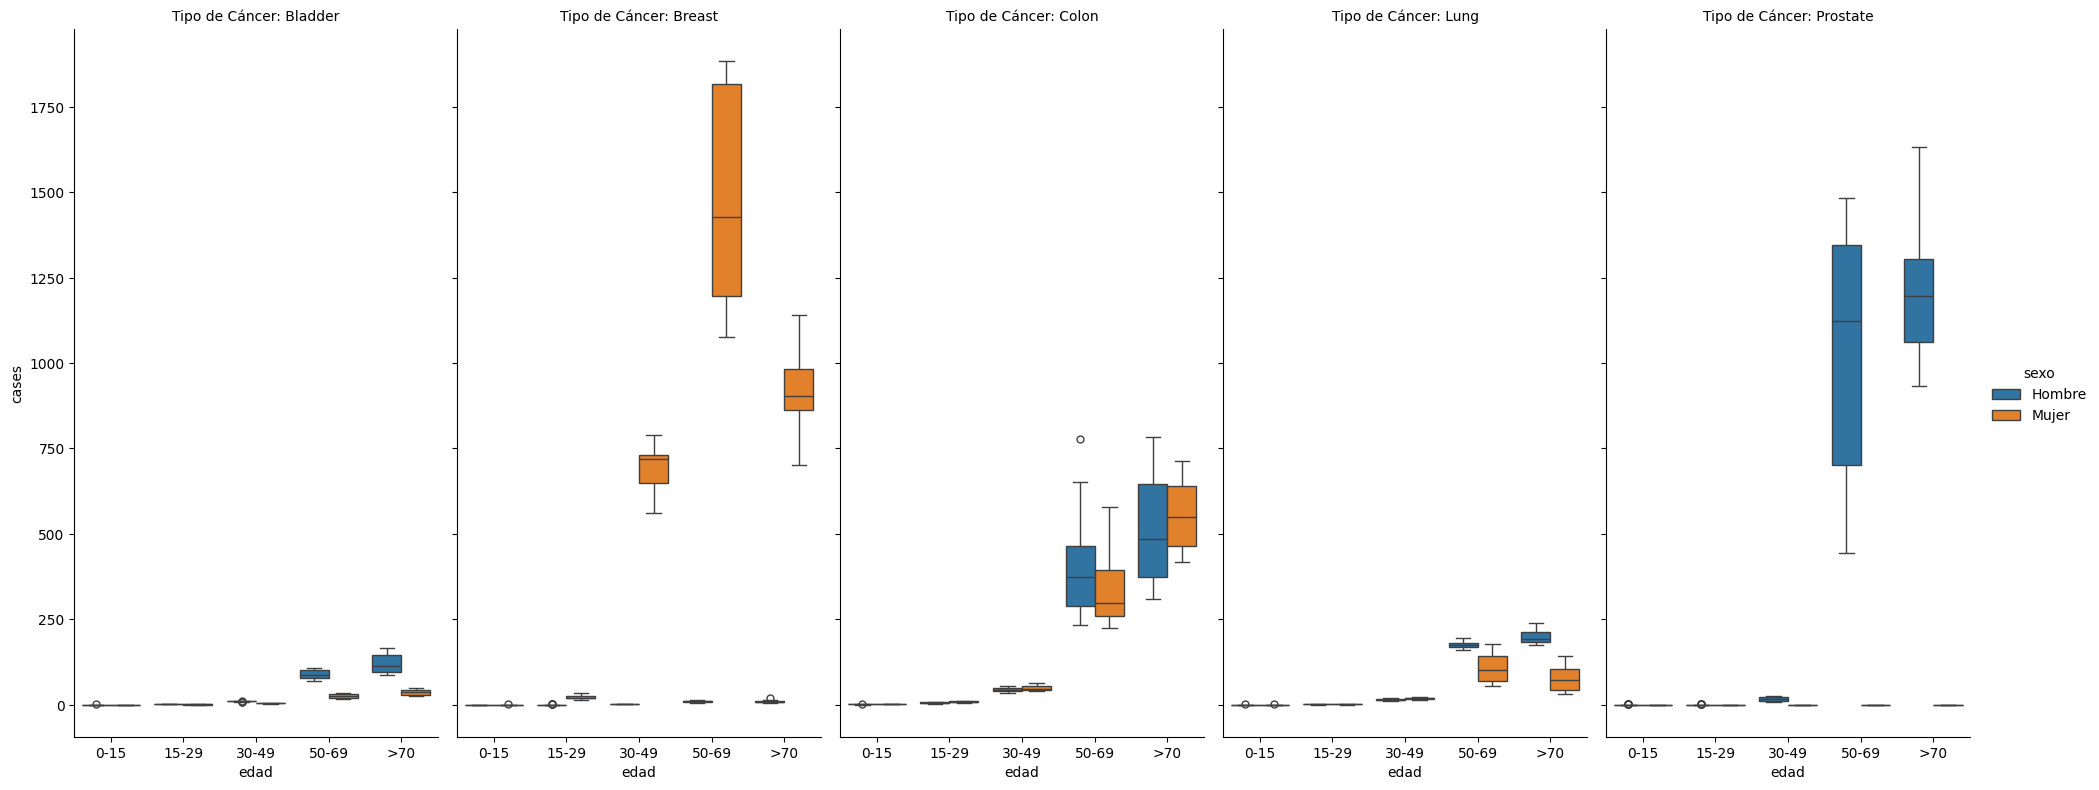

In [47]:
# Representamos gráficamente el número de casos a lo largo de los años para cada sexo y edad, 
# en cada tipo de cáncer en Holanda

b = sns.catplot(x="edad",
            y="cases",
            hue="sexo",
            col="cancer_label",
            kind = "box",
            data=promedio_casos_ned,
            height=8,
            aspect=0.5)
b.set_titles("Tipo de Cáncer: {col_name}")
b;

Al igual que en UK vemos como el promedio de casos diagnosticados de los diferentes tipos de cáncer
se acumulan en los rangos de edad a partir de 30 años. También se observa la dispariedad de cifras 
entre hombres y mujeres en los casos de cánceres de hombres y mujeres. La mayor variabilidad de promedios a lo largo del periodo se observa en los casos diagnosticados de cáncer de próstata y mama.

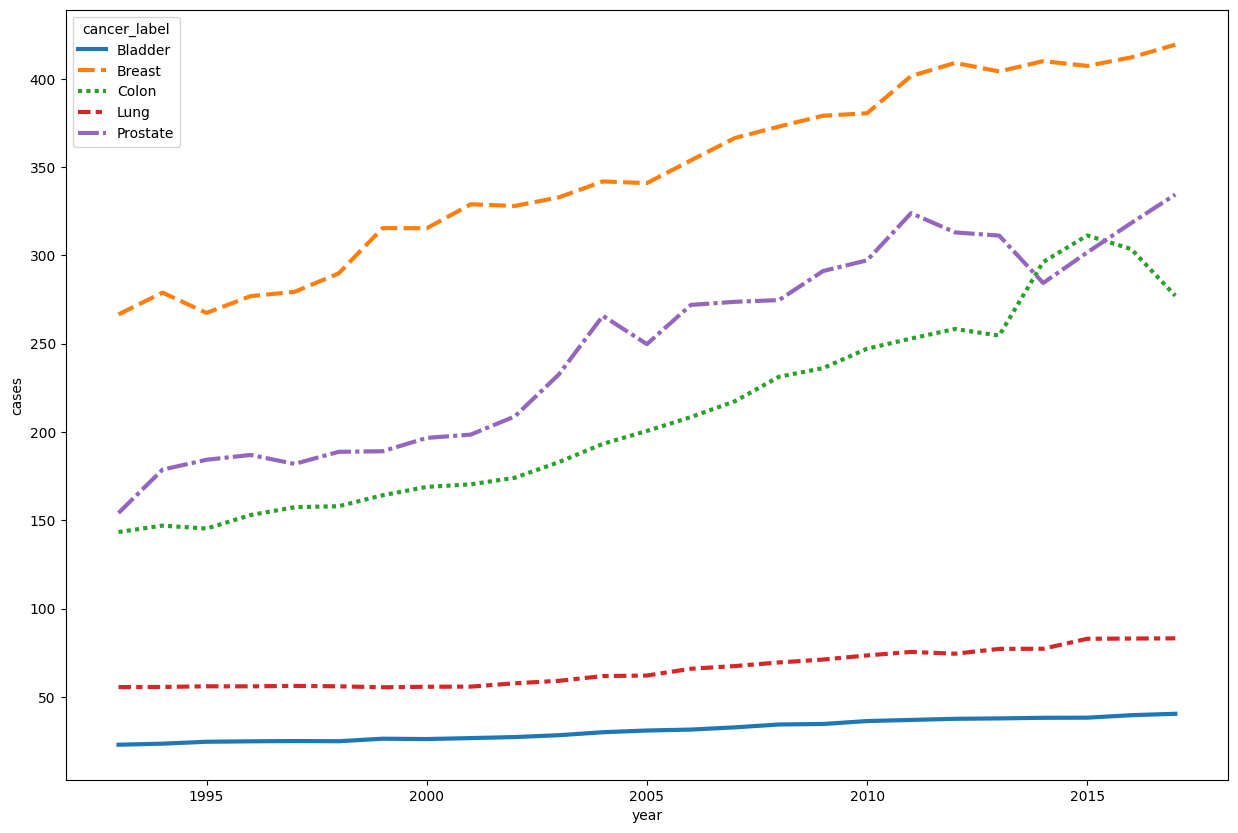

In [ ]:
# Estudiamos la evolución delpromedio de casos diagnosticados de cada tipo de cancer en el periodo
# 1993-2017 en Holanda

tipo_cancer_hol = cancer_hol.groupby(["cancer_label", "year"])[["cases"]].mean().reset_index()
tipo_cancer_uk

plt.figure(figsize=(15,10))
sns.lineplot(data=tipo_cancer_hol,
             x="year",
             y="cases",
             hue="cancer_label",
             style= "cancer_label",
            linewidth = 3);

En el gráfico se observa como en Holanda el promedio de casos de cancer de mama, próstata y colon han 
aumentado a lo largo del periodo 1993-2017.

## Conclusión

En este análisis se ha partido del supuesto de que las poblaciones de los lugares donde se han recogido datos presentan tamaños poblacionales similares, lo que es un error. Sin embargo, para los fines de este proyecto, se considera válido, y la estimación de casos por cada 100000 habitantes se ha calculado tanto para el país como para el continente como un promedio en cada caso.
Los resultados han confirmado la hipótesis inicial de que existen diferencias en el número de casos de cancer diagnosticados entre los diferentes continentes, aunque como se ha explicado en el apartado de resultados estas diferencias se pueden deber a múltiples factores. 
En Europa, el mayor número de diagnosticos a lo largo del periodo de 1993-2017 esta asociado a los cánceres de vejiga, mama, próstata, colon y pulmón. El análisis de las diferencias en el promedio de casos de los cánceres más diagnostiados a nivel europeo ha mostrado que existen un pequeño número de países, destacando Reino Unido y Holanda, que presentan en el periodo estudiado un número de casos mayor que el resto. En estos dos países, el número e diagnósticos era mayor en personas mayores de 30 años. Además, el número de cánceres de mama diagnosticados en hombres en prácticamente nulo. Como es lógico, no existen mujeres diagnosticadas de cáncer de próstata. Por último, se observa una tendencia en ambos países europeos del incremento en el número de diagnosticos en el periodo estudiado para los cánceres más comunes, excepto para el de vejiga.